In [2]:
import pandas as pd
import xgboost
from sklearn.model_selection import train_test_split
import sqlite3
import os
import shap

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
conn = sqlite3.connect("./data/Database.db")
cursor = conn.cursor()
query = "SELECT * FROM DVC0004"
df = pd.read_sql_query(query, conn)
# STUATUS_MS =1 이 정상, 2가 비정상

In [4]:
print("비정상 데이터 갯수: ", len(df[df.STATUS_MS==2]))
print("정상 데이터 갯수: ", len(df[df.STATUS_MS==1]))

비정상 데이터 갯수:  21
정상 데이터 갯수:  833263


In [5]:
# 예시 데이터 import 
# 예시 모델 학습
x = df.drop("")

model = xgboost.XGBRegressor().fit(X, y)

KeyError: "[''] not found in axis"

In [3]:
print(type(model))

<class 'xgboost.sklearn.XGBRegressor'>


In [12]:
explainer = shap.Explainer(model)
shap_values = explainer(X)

[17:09:25] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead


In [26]:
print(shap_values.__dict__)

{'op_history': [], 'compute_time': 0.01924300193786621, 'output_dims': (), '_s': Slicer({'o': [], 'values': array([[-2.0645633 ,  0.3229129 ,  3.4250062 , -0.17508136],
       [-0.1587886 , -0.6946155 ,  0.46563995, -0.18548098],
       [ 8.874442  , -0.21311583,  3.1282141 , -0.09238403],
       ...,
       [ 2.711311  , -0.3008216 , -1.2592615 , -0.14786682],
       [ 1.8276973 , -0.3396507 , -1.6782764 , -0.11290564],
       [-4.5272784 , -0.6454306 , -3.9130943 , -0.17274114]],
      dtype=float32), 'base_values': array([22.530926, 22.530926, 22.530926, 22.530926, 22.530926, 22.530926,
       22.530926, 22.530926, 22.530926, 22.530926, 22.530926, 22.530926,
       22.530926, 22.530926, 22.530926, 22.530926, 22.530926, 22.530926,
       22.530926, 22.530926, 22.530926, 22.530926, 22.530926, 22.530926,
       22.530926, 22.530926, 22.530926, 22.530926, 22.530926, 22.530926,
       22.530926, 22.530926, 22.530926, 22.530926, 22.530926, 22.530926,
       22.530926, 22.530926, 22.530926

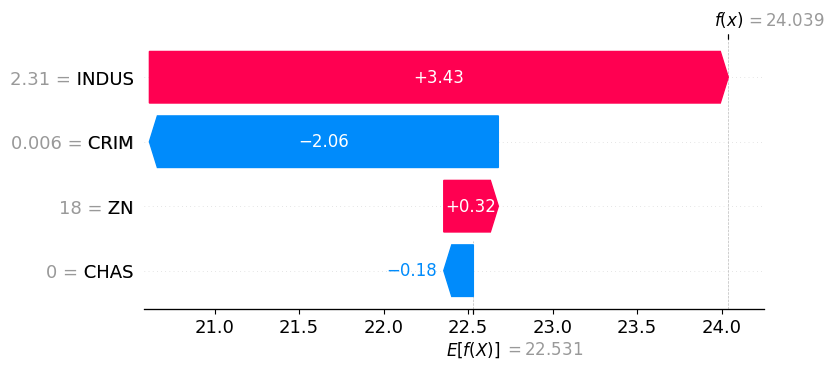

In [5]:
shap.plots.waterfall(shap_values[0])

In [28]:
print(shap_values[0].__dict__)

{'op_history': [{'name': '__getitem__', 'args': ((0,),), 'prev_shape': (506, 4)}], 'compute_time': None, 'output_dims': (), '_s': Slicer({'o': [], 'values': array([-2.0645633 ,  0.3229129 ,  3.4250062 , -0.17508136], dtype=float32), 'base_values': 22.530926, 'data': array([6.32e-03, 1.80e+01, 2.31e+00, 0.00e+00]), 'display_data': None, 'instance_names': None, 'output_names': None, 'output_indexes': None, 'lower_bounds': None, 'upper_bounds': None, 'error_std': None, 'main_effects': None, 'hierarchical_values': None, 'clustering': None})}


In [31]:
X.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS'], dtype='object')